# Ames housing

In [7]:
# PEP-8: group imports from standard library first, alphabetical order
from pathlib import Path # use pathlib for working with paths
import sys
import tarfile
import warnings

# imports from third-party modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests.compat import urljoin
import sklearn
import seaborn as sns


In [4]:
import pandas as pd

ames = pd.read_csv("https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true")
ames.shape

(2930, 82)

In [3]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

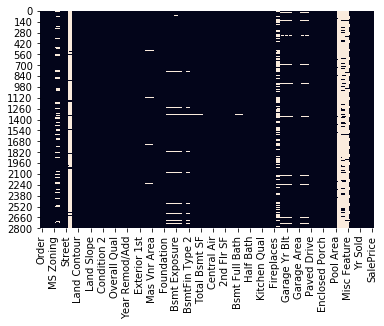

In [9]:
sns.heatmap(ames.isnull(), cbar=False)